In [1]:
%matplotlib inline

## Edges and lines

### contour finding
- uses __marching squares__(special case of __marching_cubes__) to find constant valued contours
- __skimage.measure.find_contours_


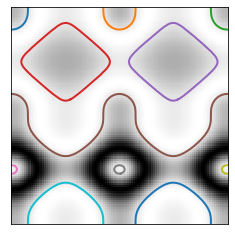

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

# Construct some test data
# Find contours at a constant value of 0.8

x, y     = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
r        = np.sin(np.exp((np.sin(x)**3 + np.cos(y)**2)))
contours = measure.find_contours(r, 0.8)

# -----------------------------------------------------
fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### convex hulls (of binary images)
- def: all pixels included in smallest convex polygon
- that surrounds all white pixels in input
- good reference: [mathworks blog](https://blogs.mathworks.com/steve/2011/10/04/binary-image-convex-hull-algorithm-notes/)

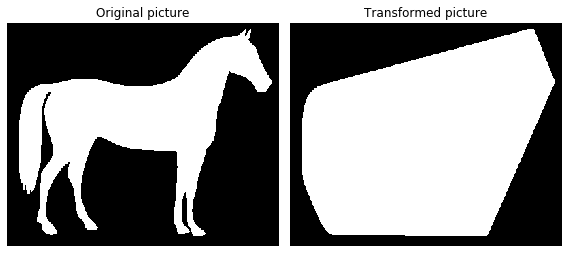

In [3]:
import matplotlib.pyplot as plt

from skimage.morphology import convex_hull_image
from skimage            import data, img_as_float
from skimage.util       import invert

# The original image is inverted as the object must be white.
image = invert(data.horse())
chull = convex_hull_image(image)

# ------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].set_title('Original picture')
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_axis_off()

ax[1].set_title('Transformed picture')
ax[1].imshow(chull, cmap=plt.cm.gray)
ax[1].set_axis_off()

plt.tight_layout()
plt.show()

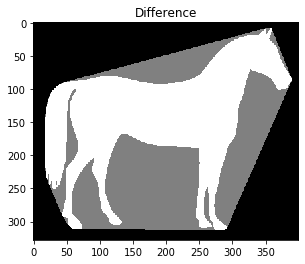

In [4]:
# 2nd plot - shows difference

chull_diff = img_as_float(chull.copy())
chull_diff[image] = 2
# ----------------------------------------------

fig, ax = plt.subplots()
ax.imshow(chull_diff, cmap=plt.cm.gray)
ax.set_title('Difference')
plt.show()

### canny filters
- multi-stage edge detector.
- uses filter based on Gaussian derivative to compute gradient intensities.
- Gaussian reduces noise effects
- potential edges thinned to 1px curves 
- edge px kept or removed w/ hysteresis thresholding.
- three params: _gaussian width_, _low threshold_, _high threshold_.

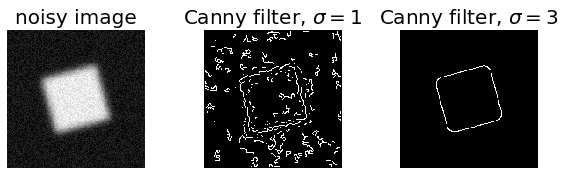

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy   import ndimage as ndi
from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im  = ndi.rotate(im, 15, mode='constant')
im  = ndi.gaussian_filter(im, 4)
im += 0.2*np.random.random(im.shape)

# Compute Canny filter for two values of sigma
edges1, edges2 = feature.canny(im), feature.canny(im, sigma=3)

# -------------------------------------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### marching cubes
- algorithm used to extract 2D surface mesh from a 3D volume.
- iterates across volume, looking for regions crossing level of interest.
- if found, triangulations generated & added to output mesh.
- final result = set of vertices, set of triangular faces.
- params: data volume, isosurface values.
- example (CT imaging): Hounsfield units of 700-3000 = bone
- also works on anisotropic datasets - where voxel spacing not same for each dimension.

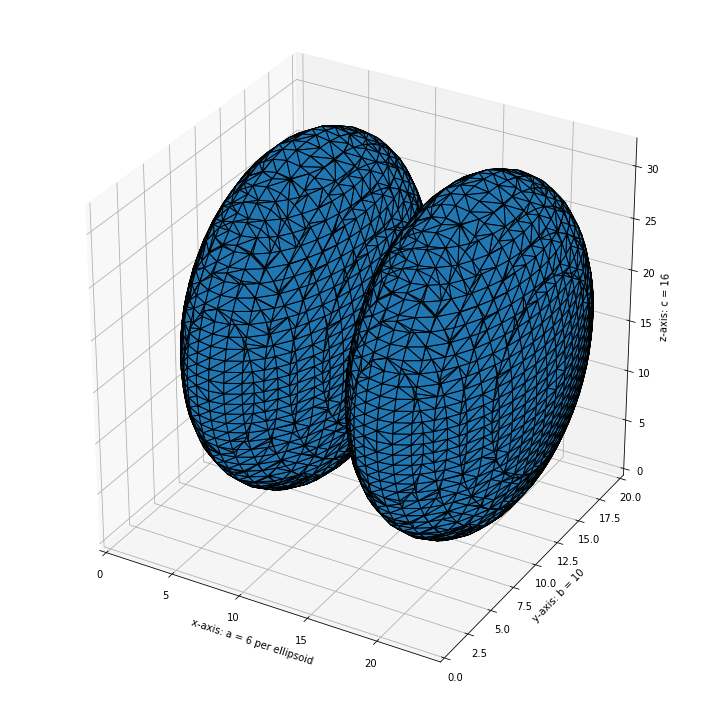

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage                    import measure
from skimage.draw               import ellipsoid

# Generate level set about zero of two identical ellipsoids in 3D
ellip_base   = ellipsoid(6, 10, 16, levelset=True)
ellip_double = np.concatenate((ellip_base[:-1, ...],
                               ellip_base[2:, ...]), axis=0)

# obtain the surface mesh of the ellipsoids
verts, faces, normals, values = measure.marching_cubes_lewiner(ellip_double, 0)

#  --------------------------------------------------------------

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 24)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 20)  # b = 10
ax.set_zlim(0, 32)  # c = 16

plt.tight_layout()
plt.show()

### ridge operators
- looks for ridge-like structures: neurites, tubes, vessels, wrinkles, rivers
- relies on eigenvalues of Hessian matrix of image intensities to detect ridges
    (where intensity changes perpendicular to structure, but not along it.)
- due to edge effects - Meijering & Frangi filters = cropped 4px for best rendering.


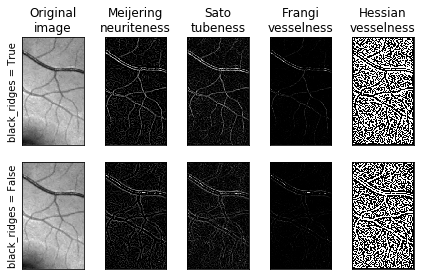

In [7]:
from skimage import data
from skimage import color
from skimage.filters import meijering, sato, frangi, hessian
import matplotlib.pyplot as plt


def identity(image, **kwargs): # return original. ignores kwargs
    return image

image            = color.rgb2gray(data.retina())[300:700, 700:900]
cmap             = plt.cm.gray
kwargs           = {}
kwargs['sigmas'] = [1]

# ------------------------------------------------------------------------
fig, axes = plt.subplots(2, 5)
for i, black_ridges in enumerate([1, 0]):
    for j, func in enumerate([
        identity, 
        meijering, 
        sato, 
        frangi, 
        hessian]):
        
        kwargs['black_ridges'] = black_ridges
        result = func(image, **kwargs)
        
        if func in (meijering, frangi):
            result = result[4:-4, 4:-4] # crop by 4px - better rendering
            
        axes[i, j].imshow(result, cmap=cmap, aspect='auto')
        if i == 0:
            axes[i, j].set_title([
                'Original\nimage', 
                'Meijering\nneuriteness',
                'Sato\ntubeness', 
                'Frangi\nvesselness',
                'Hessian\nvesselness'][j])
            
        if j == 0:
            axes[i, j].set_ylabel('black_ridges = ' + str(bool(black_ridges)))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()

### active contour model 
- method to fit open or closed splines to lines or edges in an image.
- works by minimizing energy function (part image, part spline shape)

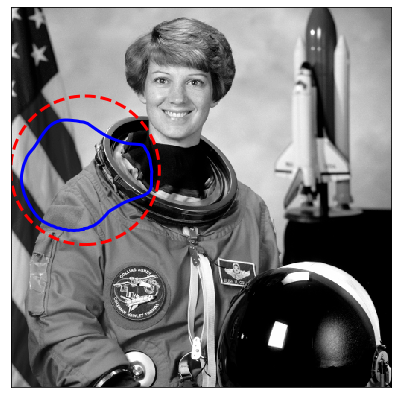

In [9]:
# example 1: 
import numpy as np
import matplotlib.pyplot as plt
from skimage.color        import rgb2gray
from skimage              import data
from skimage.filters      import gaussian
from skimage.segmentation import active_contour


img   = data.astronaut()
img   = rgb2gray(img)
s     = np.linspace(0, 2*np.pi, 400)
r     = 100 + 100*np.sin(s)
c     = 220 + 100*np.cos(s)
init  = np.array([r, c]).T
snake = active_contour(gaussian(img, 3),
                       init, alpha=0.015, beta=10, gamma=0.001,
                       coordinates='rc')

# ------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])
plt.show()

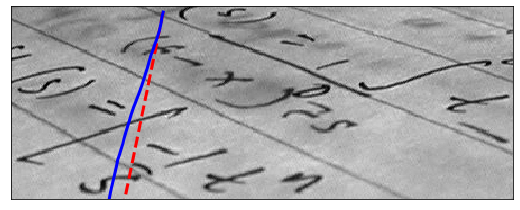

In [10]:
# below: initialize straight line bwtn 2 points
# require that the spline uses them as endpoints (bc='fixed')
# force algorithm to search for dark lines (negative w_line value)

img   = data.text()
r     = np.linspace(136, 50, 100)
c     = np.linspace(5, 424, 100)
init  = np.array([r, c]).T

snake = active_contour(gaussian(img, 1), init, boundary_condition='fixed',
                       alpha=0.1, beta=1.0, w_line=-5, w_edge=0, gamma=0.1,
                       coordinates='rc')

# --------------------------------------------
fig, ax = plt.subplots(figsize=(9, 5))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])
plt.show()

### how to draw standard shapes 
- line, bezier curve, polygon, circle, ellipse
- anti-aliased drawing for lines & circles

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


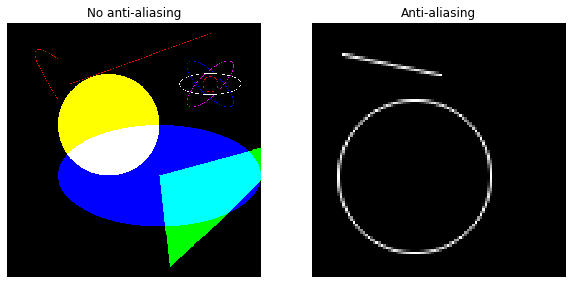

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt

from skimage.draw import (line, polygon, circle,
                          circle_perimeter,
                          ellipse, ellipse_perimeter,
                          bezier_curve)

img = np.zeros((500, 500, 3), dtype=np.double)

# draw line
rr, cc = line(120, 123, 20, 400)
img[rr, cc, 0] = 255

# fill polygon
poly = np.array((
    (300, 300),
    (480, 320),
    (380, 430),
    (220, 590),
    (300, 300),
))
rr, cc = polygon(poly[:, 0], poly[:, 1], img.shape)
img[rr, cc, 1] = 1

# fill circle
rr, cc = circle(200, 200, 100, img.shape)
img[rr, cc, :] = (1, 1, 0)

# fill ellipse
rr, cc = ellipse(300, 300, 100, 200, img.shape)
img[rr, cc, 2] = 1

# circle
rr, cc = circle_perimeter(120, 400, 15)
img[rr, cc, :] = (1, 0, 0)

# Bezier curve
rr, cc = bezier_curve(70, 100, 10, 10, 150, 100, 1)
img[rr, cc, :] = (1, 0, 0)

# ellipses
rr, cc = ellipse_perimeter(120, 400, 60, 20, orientation=math.pi / 4.)
img[rr, cc, :] = (1, 0, 1)
rr, cc = ellipse_perimeter(120, 400, 60, 20, orientation=-math.pi / 4.)
img[rr, cc, :] = (0, 0, 1)
rr, cc = ellipse_perimeter(120, 400, 60, 20, orientation=math.pi / 2.)
img[rr, cc, :] = (1, 1, 1)

# --------------------------------------------------------

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))
ax1.imshow(img)
ax1.set_title('No anti-aliasing')
ax1.axis('off')

# --------------------------------------------------------

from skimage.draw import line_aa, circle_perimeter_aa

img = np.zeros((100, 100), dtype=np.double)
# anti-aliased line
rr, cc, val = line_aa(12, 12, 20, 50)
img[rr, cc] = val
# anti-aliased circle
rr, cc, val = circle_perimeter_aa(60, 40, 30)
img[rr, cc] = val

# --------------------------------------------------------

ax2.imshow(img, cmap=plt.cm.gray)
ax2.set_title('Anti-aliasing')
ax2.axis('off')
plt.show()

### random shapes
- 1) 128x128 grayscale rectangle 
    returns tuple of image & list of label/coordinate tuples
- 2) multiple 128x128 colored rectangles
- 3) overlapping images

Image shape: (128, 128)
Labels: [('rectangle', ((41, 70), (38, 112)))]


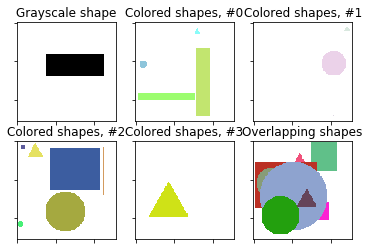

In [12]:
import matplotlib.pyplot as plt

from skimage.draw import random_shapes

result = random_shapes((128, 128), max_shapes=1, shape='rectangle',
                       multichannel=False)

image, labels = result
print(f"Image shape: {image.shape}\nLabels: {labels}")

# ------------------------------------------------------------------

fig, axes = plt.subplots(nrows=2, ncols=3)
ax = axes.ravel()
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Grayscale shape')

image1, _ = random_shapes((128, 128), max_shapes=10, intensity_range=((100, 255),))
image2, _ = random_shapes((128, 128), max_shapes=10, intensity_range=((200, 255),))
image3, _ = random_shapes((128, 128), max_shapes=10, intensity_range=(( 50, 255),))
image4, _ = random_shapes((128, 128), max_shapes=10, intensity_range=((  0, 255),))

for i, image in enumerate([image1, image2, image3, image4], 1):
    ax[i].imshow(image)
    ax[i].set_title(f"Colored shapes, #{i-1}")

image, _ = random_shapes((128, 128), min_shapes=5, max_shapes=10,
                         min_size=20, allow_overlap=True)

ax[5].imshow(image)
ax[5].set_title('Overlapping shapes')

for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
plt.show()

### straight-line hough transform
- used to detect straight lines.
- algorithm: TODO
- alternative: Progressive Hough Transform (PHT)
    - params: general threshold, min line length, line gap

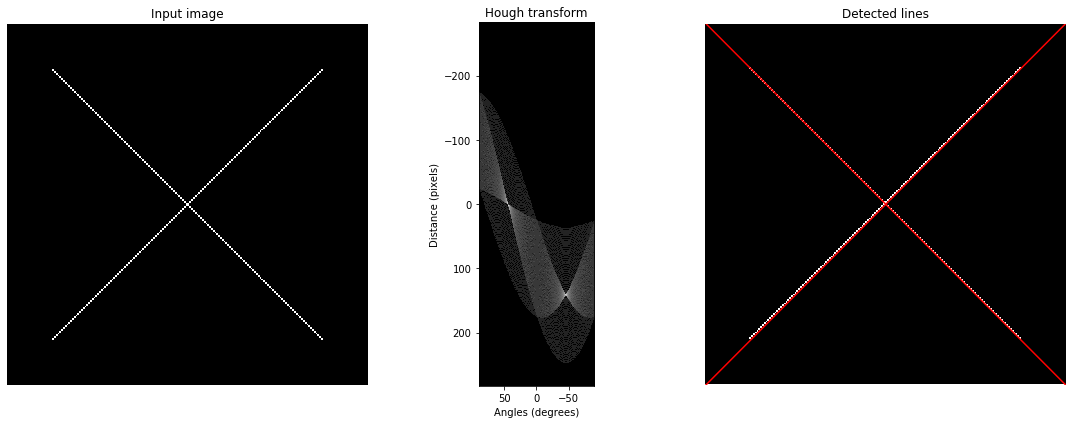

In [13]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature   import canny
from skimage           import data

import matplotlib.pyplot as plt
from matplotlib import cm

# Construct test image
image                 = np.zeros((200, 200))
idx                   = np.arange(25, 175)
image[idx[::-1], idx] = 255
image[idx, idx]       = 255

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles         = np.linspace(-np.pi/2, np.pi/2, 360)
h, theta, d           = hough_line(image, theta=tested_angles)

# ----------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_xlim(origin)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

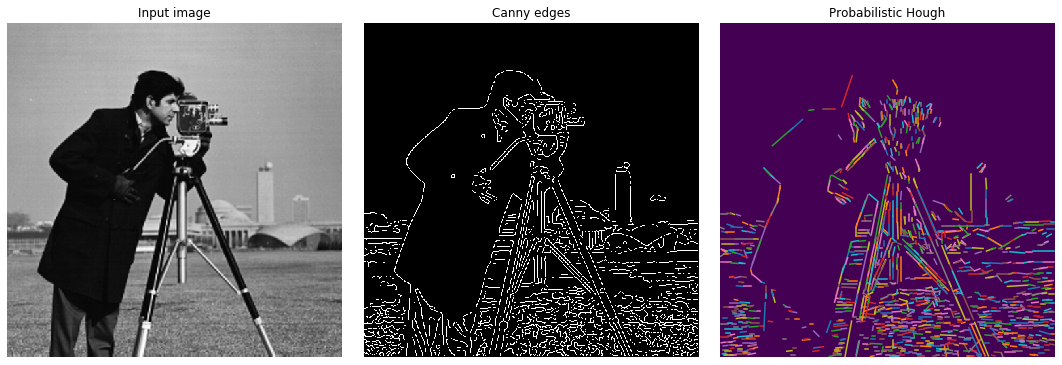

In [14]:
# probabilistic hough transform

from skimage.transform import probabilistic_hough_line

image = data.camera()
edges = canny(image, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)

# -----------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

### approximating & subdividing polygons
- approximate uses Douglas-Peucker algorithm
- subdivide uses b-splines

Number of coordinates: 22 704 26
Number of coordinates: 1173 32 9
Number of coordinates: 701 21 5


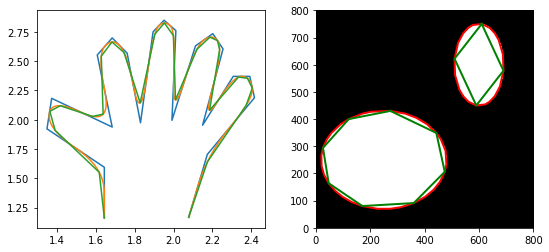

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.draw    import ellipse
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon


hand = np.array([[1.64516129, 1.16145833],
                 [1.64516129, 1.59375],
                 [1.35080645, 1.921875],
                 [1.375, 2.18229167],
                 [1.68548387, 1.9375],
                 [1.60887097, 2.55208333],
                 [1.68548387, 2.69791667],
                 [1.76209677, 2.56770833],
                 [1.83064516, 1.97395833],
                 [1.89516129, 2.75],
                 [1.9516129, 2.84895833],
                 [2.01209677, 2.76041667],
                 [1.99193548, 1.99479167],
                 [2.11290323, 2.63020833],
                 [2.2016129, 2.734375],
                 [2.25403226, 2.60416667],
                 [2.14919355, 1.953125],
                 [2.30645161, 2.36979167],
                 [2.39112903, 2.36979167],
                 [2.41532258, 2.1875],
                 [2.1733871, 1.703125],
                 [2.07782258, 1.16666667]])


# subdivide polygon using 2nd degree B-Splines
new_hand = hand.copy()
for _ in range(5):
    new_hand = subdivide_polygon(new_hand, degree=2, preserve_ends=True)

# approximate subdivided polygon with Douglas-Peucker algorithm
appr_hand = approximate_polygon(new_hand, tolerance=0.02)

print("Number of coordinates:", len(hand), len(new_hand), len(appr_hand))

# -----------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 4))

ax1.plot(hand[:, 0], hand[:, 1])
ax1.plot(new_hand[:, 0], new_hand[:, 1])
ax1.plot(appr_hand[:, 0], appr_hand[:, 1])


# create two ellipses in image
img = np.zeros((800, 800), 'int32')
rr, cc = ellipse(250, 250, 180, 230, img.shape)
img[rr, cc] = 1
rr, cc = ellipse(600, 600, 150, 90, img.shape)
img[rr, cc] = 1

plt.gray()
ax2.imshow(img)

# approximate / simplify coordinates of the two ellipses
for contour in find_contours(img, 0):
    
    coords  = approximate_polygon(contour, tolerance=2.5)
    coords2 = approximate_polygon(contour, tolerance=39.5)
    
    ax2.plot(coords[:, 1], coords[:, 0],   '-r', linewidth=2)
    ax2.plot(coords2[:, 1], coords2[:, 0], '-g', linewidth=2)
    
    print("Number of coordinates:", len(contour), len(coords), len(coords2))

ax2.axis((0, 800, 0, 800))
plt.show()

### circular, elliptical hough transforms
- circle detection:
    - below: detects coin positions & match edges
    - we provide range of plausible radii
    - for each radius: two circles extracted; keep 5 best candidates
- ellipse detection:
    - below: detect edge of a coffee cup.
    - projection of a circle
    - more difficult to solve (5 params, not just 3)

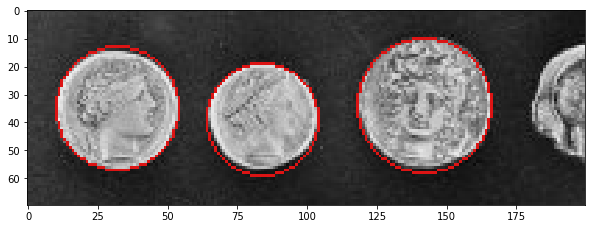

In [18]:
# circle detection

import numpy as np
import matplotlib.pyplot as plt

from skimage           import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature   import canny
from skimage.draw      import circle_perimeter
from skimage.util      import img_as_ubyte


# Load picture and detect edges
image = img_as_ubyte(data.coins()[160:230, 70:270])
edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)

# Detect two radii
hough_radii = np.arange(20, 35, 2)
hough_res   = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, 
                                           hough_radii,
                                           total_num_peaks=3)

# ---------------------------------------------------------------
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

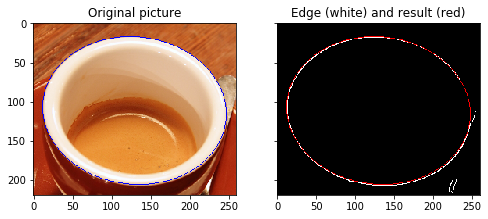

In [19]:
# ellipse detection

import matplotlib.pyplot as plt

from skimage           import data, color, img_as_ubyte
from skimage.feature   import canny
from skimage.transform import hough_ellipse
from skimage.draw      import ellipse_perimeter

# Load picture, convert to grayscale and detect edges
image_rgb  = data.coffee()[0:220, 160:420]
image_gray = color.rgb2gray(image_rgb)
edges      = canny(image_gray, sigma=2.0, 
                   low_threshold=0.55, high_threshold=0.8)

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators

result = hough_ellipse(edges, 
                       accuracy=20, 
                       threshold=250,
                       min_size=100, 
                       max_size=120)
result.sort(order='accumulator')

# Estimated parameters for the ellipse
best         = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation  = best[5]

# Draw the ellipse on the original image
# Draw the edge (white) and the resulting ellipse (red)
cy, cx            = ellipse_perimeter(yc, xc, a, b, orientation)
image_rgb[cy, cx] = (0, 0, 255)
edges             = color.gray2rgb(img_as_ubyte(edges))
edges[cy, cx]     = (250, 0, 0)

# -----------------------------------------------------------------

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                                sharex=True, sharey=True)
ax1.set_title('Original picture')
ax1.imshow(image_rgb)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()

### skeletonize
- reduces binary objects to 1-pixel-wide representations.
- useful for feature extraction & topology representationi
- works by iteratively removing border px, if they don't break object connectivity.

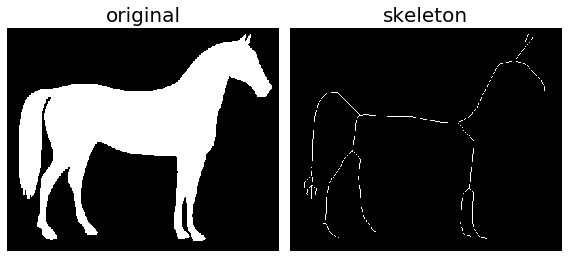

In [21]:
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage            import data
from skimage.util       import invert

# Invert horse image & perform skeletonization
image   = invert(data.horse())
skeleton = skeletonize(image)

# -----------------------------------------------------------
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()

#### Zhang method vs Lee method:
- skeletonize(...,method="lee") - evaluates 3x3x3 px neighborhood.
- designed for 3D images, auto-selected. applied to 2D image in this example.

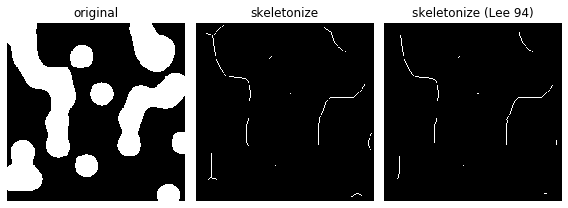

In [22]:
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.data import binary_blobs


data = binary_blobs(200, blob_size_fraction=.2, volume_fraction=.35, seed=1)

skeleton = skeletonize(data)
skeleton_lee = skeletonize(data, method='lee')

fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(data, cmap=plt.cm.gray)
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].set_title('skeletonize')
ax[1].axis('off')

ax[2].imshow(skeleton_lee, cmap=plt.cm.gray)
ax[2].set_title('skeletonize (Lee 94)')
ax[2].axis('off')

fig.tight_layout()
plt.show()

#### Medial axis skeletonization
- medial axis: set of all points with >1 closest point on object's boundary.

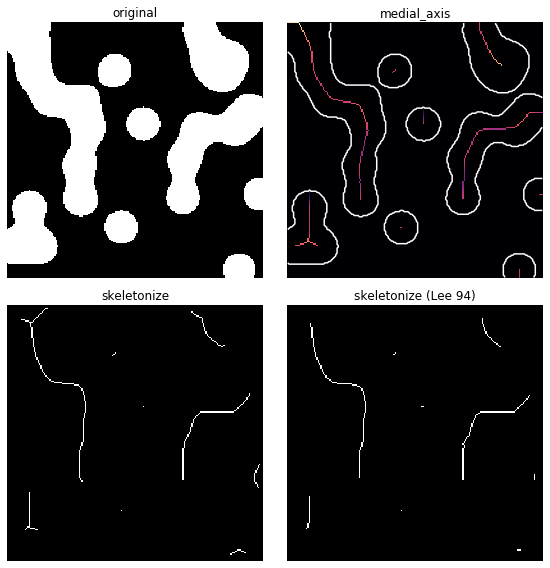

In [23]:
from skimage.morphology import medial_axis, skeletonize

# Generate the data
# Compute the medial axis (skeleton) and the distance transform
# Compare with other skeletonization algorithms
# Distance to the background for pixels of the skeleton

data           = binary_blobs(200, 
                              blob_size_fraction=.2, 
                              volume_fraction=.35, 
                              seed=1)
skel, distance = medial_axis(data, 
                             return_distance=True)
skeleton       = skeletonize(data)
skeleton_lee   = skeletonize(data, 
                             method='lee')
dist_on_skel   = distance * skel

# ----------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(data, cmap=plt.cm.gray)
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(dist_on_skel, cmap='magma')
ax[1].contour(data, [0.5], colors='w')
ax[1].set_title('medial_axis')
ax[1].axis('off')

ax[2].imshow(skeleton, cmap=plt.cm.gray)
ax[2].set_title('skeletonize')
ax[2].axis('off')

ax[3].imshow(skeleton_lee, cmap=plt.cm.gray)
ax[3].set_title("skeletonize (Lee 94)")
ax[3].axis('off')

fig.tight_layout()
plt.show()

#### mophological thinning
- same principle as _skeletonize_
- optional _max_iter_ keyword limits # of iterations = relatively thicker skeleton.

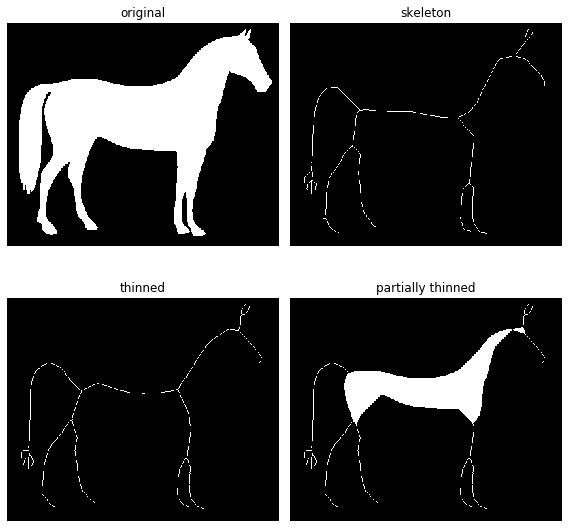

In [24]:
from skimage.morphology import skeletonize, thin

skeleton = skeletonize(image)
thinned = thin(image)
thinned_partial = thin(image, max_iter=25)

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].set_title('skeleton')
ax[1].axis('off')

ax[2].imshow(thinned, cmap=plt.cm.gray)
ax[2].set_title('thinned')
ax[2].axis('off')

ax[3].imshow(thinned_partial, cmap=plt.cm.gray)
ax[3].set_title('partially thinned')
ax[3].axis('off')

fig.tight_layout()
plt.show()

### edge operators
- various discrete differentiation routines
- roberts, 
- sobel,   sobel_v,   sobel_h, 
- scharr,  scharr_v,  scharr_h,
- prewitt, prewitt_v, prewitt_h,
-          farid_v,   farid_h
- computes approximation of image intensity gradient.

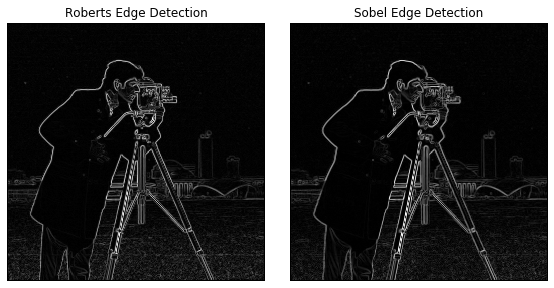

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import camera
from skimage.filters import roberts, sobel, sobel_h, sobel_v, scharr, \
    scharr_h, scharr_v, prewitt, prewitt_v, prewitt_h, farid_v, farid_h

image        = camera()
edge_roberts = roberts(image)
edge_sobel   = sobel(image)

# -------------------------------------------------------
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(8, 4))

ax[0].imshow(edge_roberts, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

#### Prewitt vs Sobel vs Scharr filters
- below: differences illustrated with image that is 
- a discretization of a rotation-invariant continuous function.

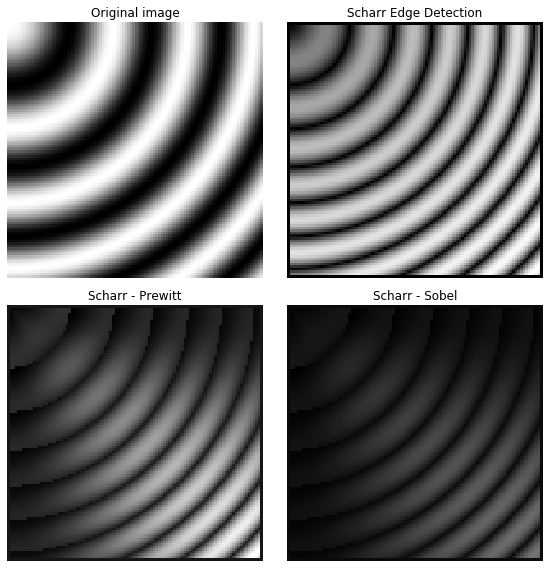

In [26]:
# Rotation-invariant image with different spatial frequencies
x, y = np.ogrid[:100, :100]
img = np.exp(1j * np.hypot(x, y) ** 1.3 / 20.).real

edge_sobel          = sobel(img)
edge_scharr         = scharr(img)
edge_prewitt        = prewitt(img)
diff_scharr_prewitt = edge_scharr - edge_prewitt
diff_scharr_sobel   = edge_scharr - edge_sobel
max_diff            = np.max(
    np.maximum(
        diff_scharr_prewitt, 
        diff_scharr_sobel))

# ------------------------------------------------------------------
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                         figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(edge_scharr, cmap=plt.cm.gray)
ax[1].set_title('Scharr Edge Detection')

ax[2].imshow(diff_scharr_prewitt, cmap=plt.cm.gray, vmax=max_diff)
ax[2].set_title('Scharr - Prewitt')

ax[3].imshow(diff_scharr_sobel, cmap=plt.cm.gray, vmax=max_diff)
ax[3].set_title('Scharr - Sobel')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

- below: (again) illustrating rotational invariance of filters.
- top row: image with angle of gradient.
- 2nd, 3rd rows: difference btwn various approximations & analytical gradient.
- Farid & Simoncelli derivatives require 5x5 kernels = computationally more expensive.

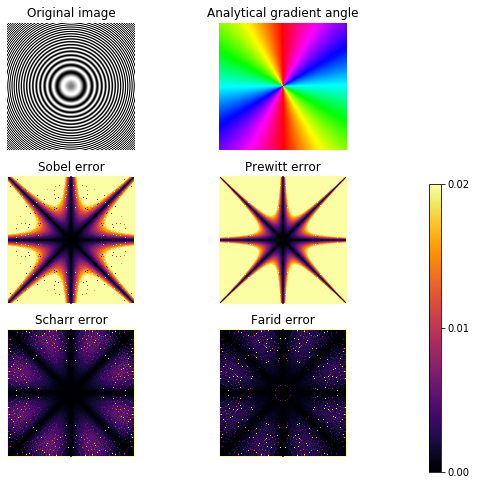

In [27]:
x, y = np.mgrid[-10:10:255j, -10:10:255j]
img = np.sin(x ** 2 + y ** 2)

imgx = 2*x * np.cos(x**2 + y**2)
imgy = 2*y * np.cos(x**2 + y**2)


def angle(dx, dy):
    return np.mod(np.arctan2(dy, dx), np.pi)

true_angle    = angle(imgx,           imgy)
angle_farid   = angle(farid_h(img),   farid_v(img))
angle_sobel   = angle(sobel_h(img),   sobel_v(img))
angle_scharr  = angle(scharr_h(img),  scharr_v(img))
angle_prewitt = angle(prewitt_h(img), prewitt_v(img))


def diff_angle(angle_1, angle_2):
    return np.minimum(np.pi - np.abs(angle_1 - angle_2),
                      np.abs(angle_1 - angle_2))


diff_farid   = diff_angle(true_angle, angle_farid)
diff_sobel   = diff_angle(true_angle, angle_sobel)
diff_scharr  = diff_angle(true_angle, angle_scharr)
diff_prewitt = diff_angle(true_angle, angle_prewitt)

# -----------------------------------------------------
fig, axes = plt.subplots(nrows=3, ncols=2, 
                         sharex=True, sharey=True,
                         figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(img,          cmap=plt.cm.gray)
ax[1].imshow(true_angle,   cmap=plt.cm.hsv)
ax[2].imshow(diff_sobel,   cmap=plt.cm.inferno, vmin=0, vmax=0.02)
ax[3].imshow(diff_prewitt, cmap=plt.cm.inferno, vmin=0, vmax=0.02)
ax[4].imshow(diff_scharr,  cmap=plt.cm.inferno, vmin=0, vmax=0.02)

cax = ax[5].imshow(diff_farid, cmap=plt.cm.inferno, vmin=0, vmax=0.02)

ax[0].set_title('Original image')
ax[1].set_title('Analytical gradient angle')
ax[2].set_title('Sobel error')
ax[3].set_title('Prewitt error')
ax[4].set_title('Scharr error')
ax[5].set_title('Farid error')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.10, 0.02, 0.50])
fig.colorbar(cax, cax=cbar_ax, ticks=[0, 0.01, 0.02])

for a in ax:
    a.axis('off')
plt.show()